In [8]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib import patheffects
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import xarray as xr

In [9]:
# Plotting Max and Min data points
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    outline_effect = [patheffects.withStroke(linewidth=2.5, foreground='black')]

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == np.array(data))
    
    lon, lat = np.meshgrid(lons, lats)

    for i in range(len(mxy)):
        A = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        A.set_path_effects(outline_effect)
        
        a = np.array(data[mxy[i], mxx[i]])
        a_trunc = np.trunc(a)
        
        B = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(a_trunc),
                color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        B.set_path_effects(outline_effect)

In [10]:
# Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_Pressure Levels.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, level: 20, time: 72)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 1 100 150 200 250 300 ... 750 800 850 900 950 1000
  * time       (time) datetime64[ns] 2016-08-13 ... 2016-08-15T23:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    pv         (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 07:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [11]:
# Open another ERA5 dataset (optional); change name accordingly to yours
ds1 = xr.open_dataset('EU_AveRain.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, time: 24)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T23:00:00
Data variables:
    cl         (time, latitude, longitude) float32 ...
    mtpr       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-09-23 02:48:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [12]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude
lons = ds.longitude

# Select and grab data
w = ds['w']
geop = ds['z'] 
geop_w_units = geop * units('m ** 2 / s ** 2')
z = mpcalc.geopotential_to_height(geop_w_units)
uwnd = ds['u']
vwnd = ds['v']
rain = ds1['mtpr']

# Select and grab 700-hPa geopotential heights and wind components, smooth with gaussian_filter
w_700 = gaussian_filter(w.sel(level=700).data[30], sigma=3.0) * units('Pa/s')
hght_700 = gaussian_filter(z.sel(level=700).data[30], sigma=3.0) * units('m')
hght_700dm = hght_700.to(units.decameter)

# Add precipitation and convert to mm/hr. Smooth with gaussian_filter
precip = gaussian_filter(rain.data[6], sigma=3.0) * units('kg/m^2/s')
mmhr1 = precip * (1 * units('m^3')) / (1000 * units('kg'))
mmhr2 = mmhr1 * (1000 * units('mm')) / (1 * units.meters)
mmhr = mmhr2.to('mm/hr') #Conversion

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds1.time.data[6].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

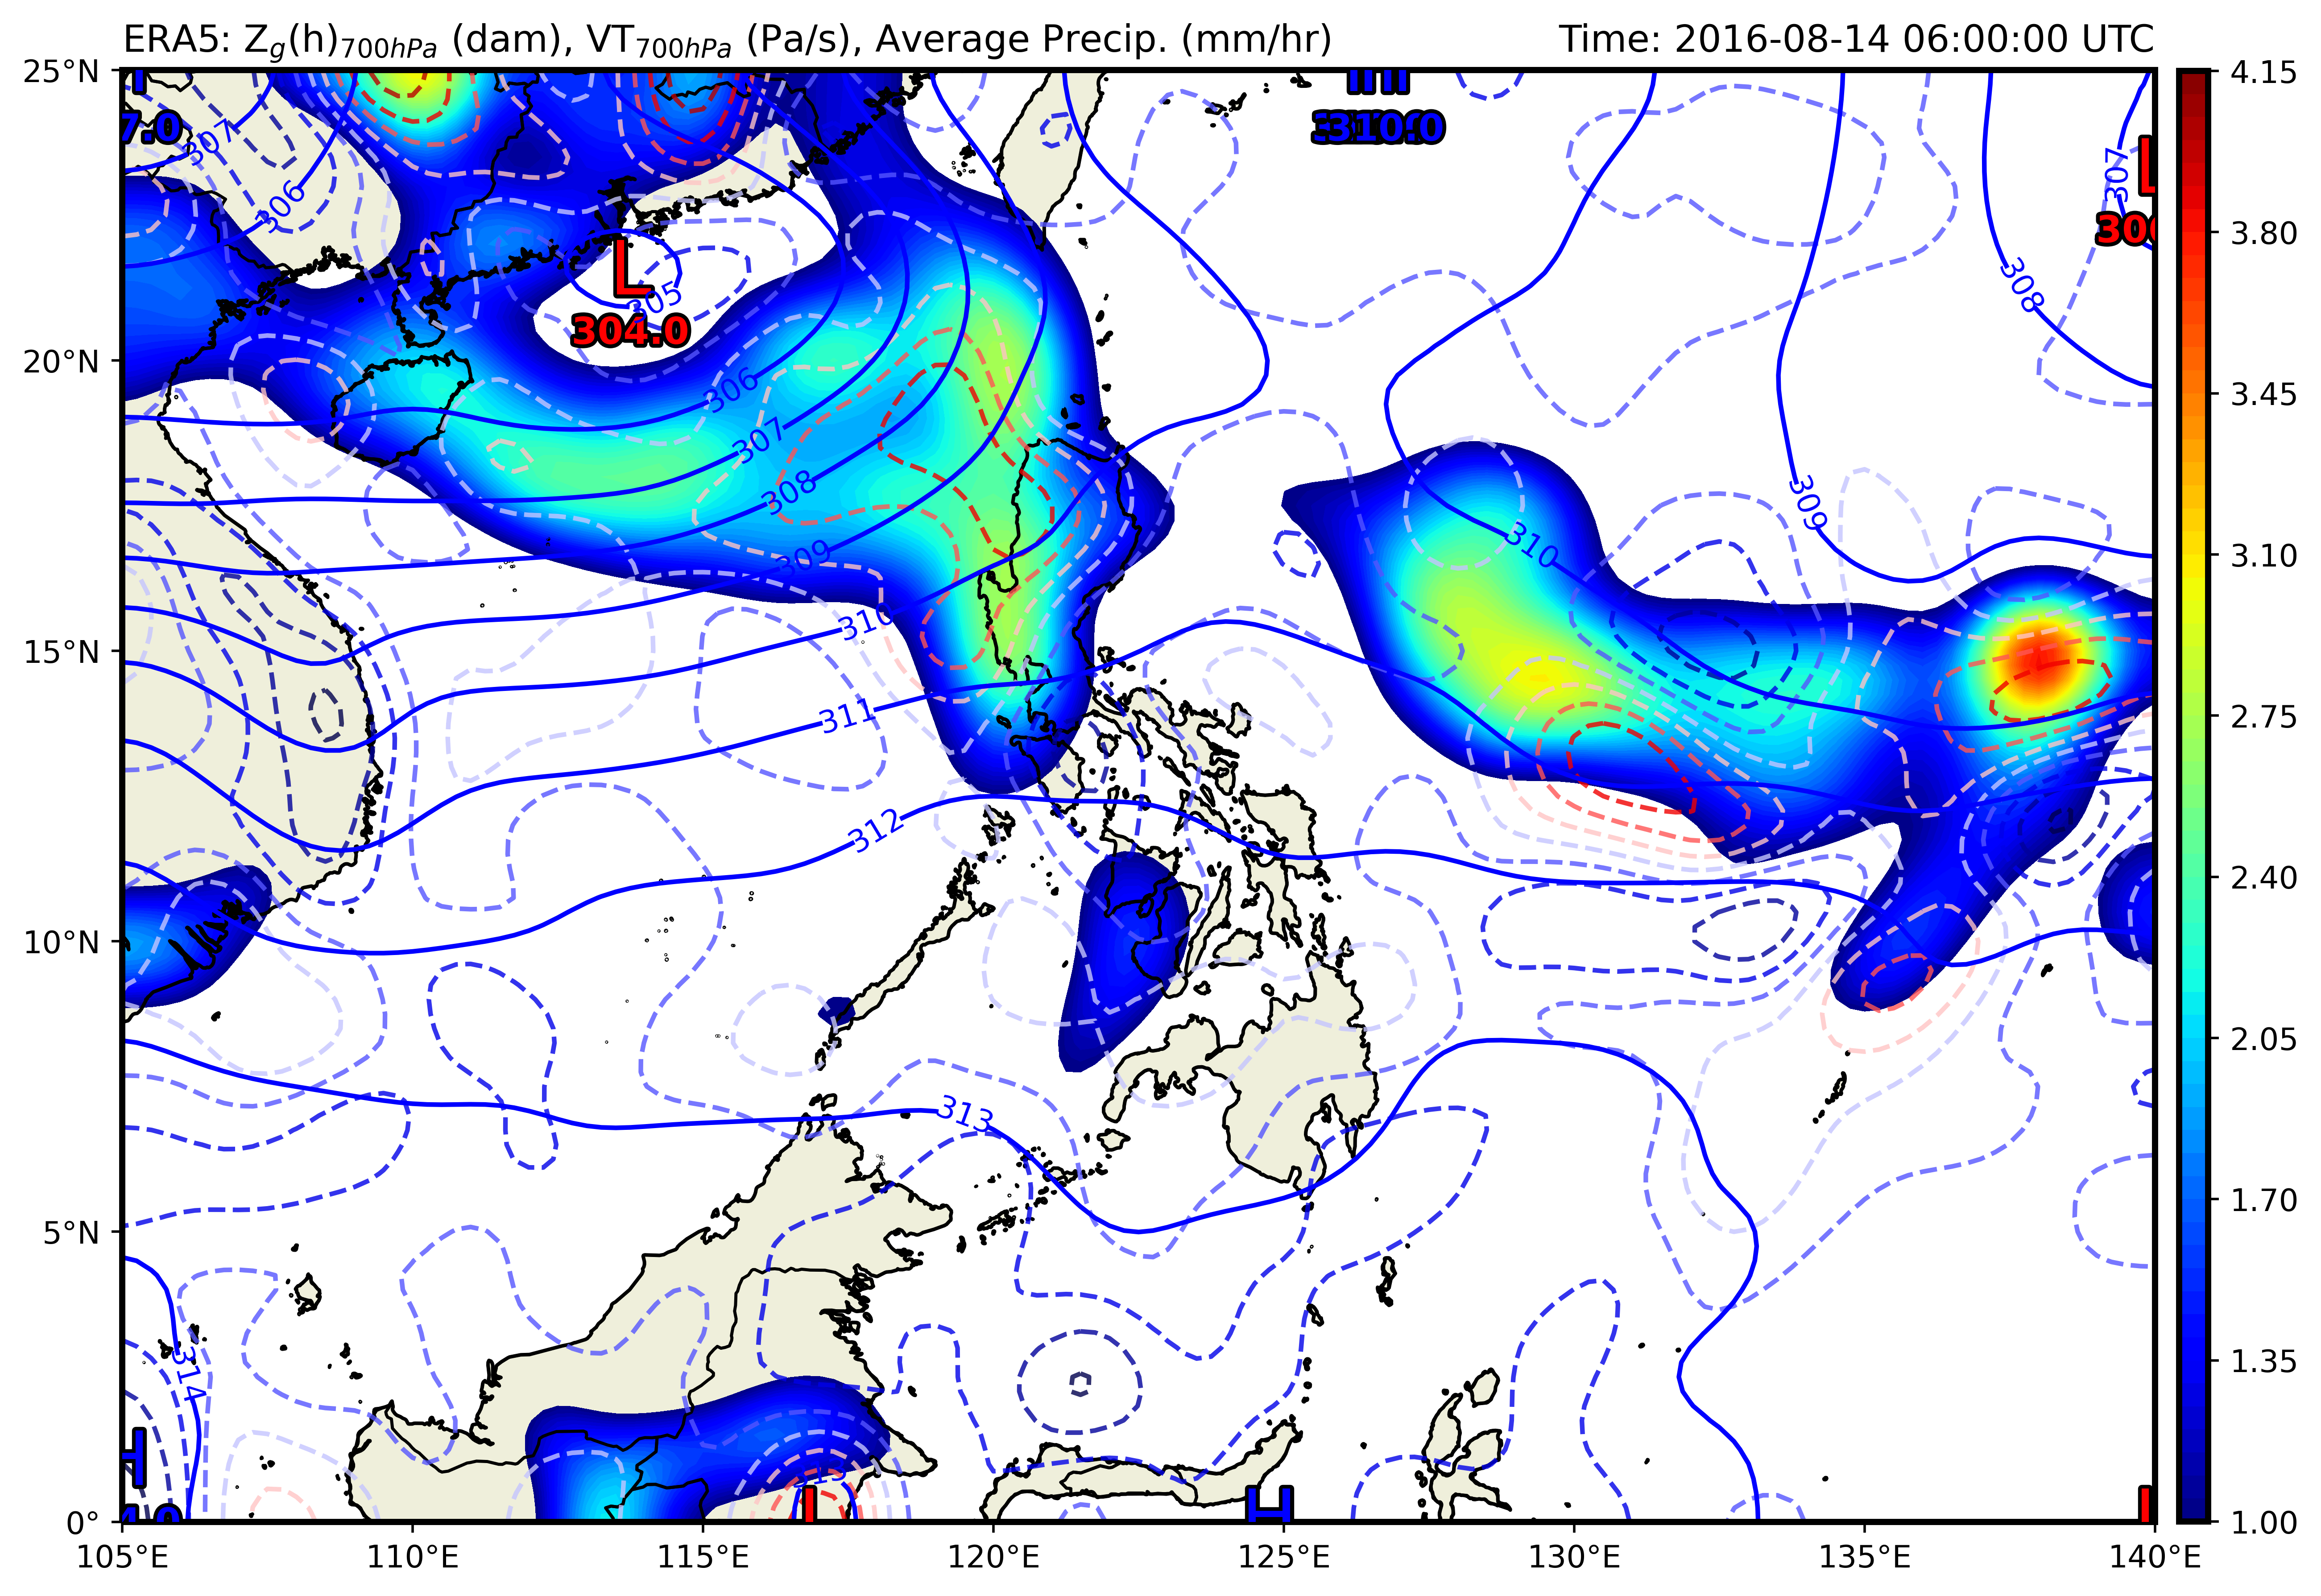

In [13]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'], zorder=1)
ax.add_feature(land_10m)

# Highlight boundary on VT
clevs_700_vtt = np.arange(-0.65, 0.35, 0.10)
ax.contour(lons, lats, w_700, clevs_700_vtt, cmap='seismic_r', 
           transform=datacrs, alpha=0.8, linestyles='--')

# Plot 700-hPa Geopotential Heights in meters
clevs_700_hght = np.arange(305, 315, 1)
cs = ax.contour(lons, lats, hght_700dm, clevs_700_hght, colors='blue',
                transform=datacrs)
ax.clabel(cs, fmt='%d')

# Plot contours of Average Total Precipitation Rate
limit = np.arange(1, 4.15, 0.05)
cf = ax.contourf(lons, lats, mmhr, limit, cmap="jet", transform=datacrs)
plt.colorbar(cf, orientation='vertical', pad=0.01, aspect=50, shrink=0.542)

# Plot Highs and Lows (Min/Max) values of Geopotential Height
plot_maxmin_points(lons, lats, hght_700dm, 'max', 40, symbol='H', color='b', transform=datacrs)
plot_maxmin_points(lons, lats, hght_700dm, 'min', 20, symbol='L', color='r', transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('ERA5: Z$_{g}$(h)$_{700hPa}$ (dam), VT$_{700hPa}$ (Pa/s), Average Precip. (mm/hr)', loc='left')
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Set X and Y-ticks for Latitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.minorticks_off()

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('GPM, VT, Rains.jpg', bbox_inches="tight")
plt.show()